In [2]:
import torch
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deep_model = DeepUNet3D(in_channels=1, out_channels=1).to(device)
deep_model.load_state_dict(torch.load('../Modèles/3D/deep_3d_20_epoch_+_25.pth', map_location=device))

summary(deep_model, input_size)  

C:\Users\User\AppData\Local\Temp\ipykernel_4676\735339844.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_model.load_state_dict(torch.load('../Modèles/3D/deep_3d_20

TypeError: summary() missing 1 required positional argument: 'input_size'

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

# U-Net 3D plus profond
class DeepUNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        # Encoder (4 niveaux)
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = conv_block(128, 256)
        self.pool4 = nn.MaxPool3d(2)
        # Bottleneck
        self.bottleneck = conv_block(256, 512)
        # Decoder (4 niveaux)
        self.up4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)
    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        b = self.bottleneck(p4)
        d4 = self.up4(b)
        d4 = F.interpolate(d4, size=e4.shape[2:], mode='trilinear', align_corners=False)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.out_conv(d1)

# Affichage des informations des modèles 3D U-Net
Cette section permet d'afficher les informations principales de tous les modèles présents dans le dossier `../Modèles/3D/`.

In [3]:
import os

# Lister tous les fichiers de modèles dans le dossier
model_dir = "../Modèles/3D/"
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
print("Modèles trouvés :")
for f in model_files:
    print("-", f)

Modèles trouvés :
- 50_epoch.pth
- best_3d_unet_model.pth
- deep_3d_20_epoch.pth
- deep_3d_20_epoch_+_25.pth
- deep_unet3d_best.pth
- new_3d.pth
- teeest.pth


In [4]:
from torchsummary import summary

# Afficher les informations pour chaque modèle trouvé
for model_file in model_files:
    print(f"\n=== {model_file} ===")
    model_path = os.path.join(model_dir, model_file)
    model = DeepUNet3D(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    # Afficher le résumé du modèle
    try:
        summary(model, (1, 64, 64, 64))  # Adapter la taille d'entrée si besoin
    except Exception as e:
        print("Erreur lors de l'affichage du résumé :", e)
    # Nombre total de paramètres
    total_params = sum(p.numel() for p in model.parameters())
    print("Nombre total de paramètres :", total_params)


=== 50_epoch.pth ===


C:\Users\User\AppData\Local\Temp\ipykernel_4676\817623915.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devic

RuntimeError: Error(s) in loading state_dict for DeepUNet3D:
	Missing key(s) in state_dict: "enc1.0.weight", "enc1.0.bias", "enc1.2.weight", "enc1.2.bias", "enc2.0.weight", "enc2.0.bias", "enc2.2.weight", "enc2.2.bias", "enc3.0.weight", "enc3.0.bias", "enc3.2.weight", "enc3.2.bias", "enc4.0.weight", "enc4.0.bias", "enc4.2.weight", "enc4.2.bias", "up4.weight", "up4.bias", "dec4.0.weight", "dec4.0.bias", "dec4.2.weight", "dec4.2.bias", "up3.weight", "up3.bias", "dec3.0.weight", "dec3.0.bias", "dec3.2.weight", "dec3.2.bias", "up2.weight", "up2.bias", "dec2.0.weight", "dec2.0.bias", "dec2.2.weight", "dec2.2.bias", "up1.weight", "up1.bias", "dec1.0.weight", "dec1.0.bias", "dec1.2.weight", "dec1.2.bias", "out_conv.weight", "out_conv.bias". 
	Unexpected key(s) in state_dict: "encoder1.0.weight", "encoder1.0.bias", "encoder1.2.weight", "encoder1.2.bias", "encoder2.0.weight", "encoder2.0.bias", "encoder2.2.weight", "encoder2.2.bias", "encoder3.0.weight", "encoder3.0.bias", "encoder3.2.weight", "encoder3.2.bias", "upconv3.weight", "upconv3.bias", "decoder3.0.weight", "decoder3.0.bias", "decoder3.2.weight", "decoder3.2.bias", "upconv2.weight", "upconv2.bias", "decoder2.0.weight", "decoder2.0.bias", "decoder2.2.weight", "decoder2.2.bias", "upconv1.weight", "upconv1.bias", "decoder1.0.weight", "decoder1.0.bias", "decoder1.2.weight", "decoder1.2.bias", "output.weight", "output.bias". 
	size mismatch for bottleneck.0.weight: copying a param with shape torch.Size([256, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3, 3]).
	size mismatch for bottleneck.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for bottleneck.2.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for bottleneck.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).

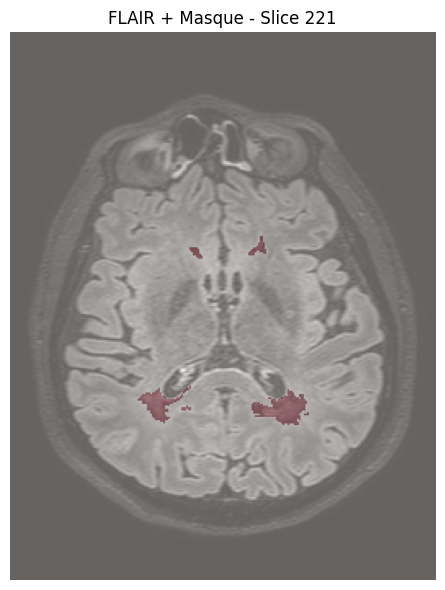

In [6]:
# Afficher la slice axiale 221 et superposer le masque sur le FLAIR pour un patient donné

import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

# --- Paramètres ---
root_dir = '../data'  # Chemin racine des données (adapter si besoin)
patient_name = '08037ROGU'  # Remplace par le nom du patient voulu
slice_idx = 221  # Index de la slice axiale à afficher

# --- Chemins des fichiers ---
patient_path = os.path.join(root_dir, patient_name)
flair_path = os.path.join(patient_path, '3DFLAIR.nii')
mask_path = os.path.join(patient_path, 'Consensus.nii')

# --- Chargement des images ---
flair_img = sitk.GetArrayFromImage(sitk.ReadImage(flair_path))  # shape: [Z, Y, X]
mask_img = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

# --- Vérification de l'index ---
if slice_idx >= flair_img.shape[0]:
    raise ValueError(f"slice_idx={slice_idx} hors limites (max={flair_img.shape[0]-1})")

# --- Extraction de la slice axiale ---
img_slice = flair_img[slice_idx, :, :]
mask_slice = mask_img[slice_idx, :, :]

# --- Affichage superposé ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_slice, cmap='gray')
ax.imshow(mask_slice, cmap='Reds', alpha=0.4)
ax.set_title(f'FLAIR + Masque - Slice {slice_idx}')
ax.axis('off')
plt.tight_layout()
plt.show()

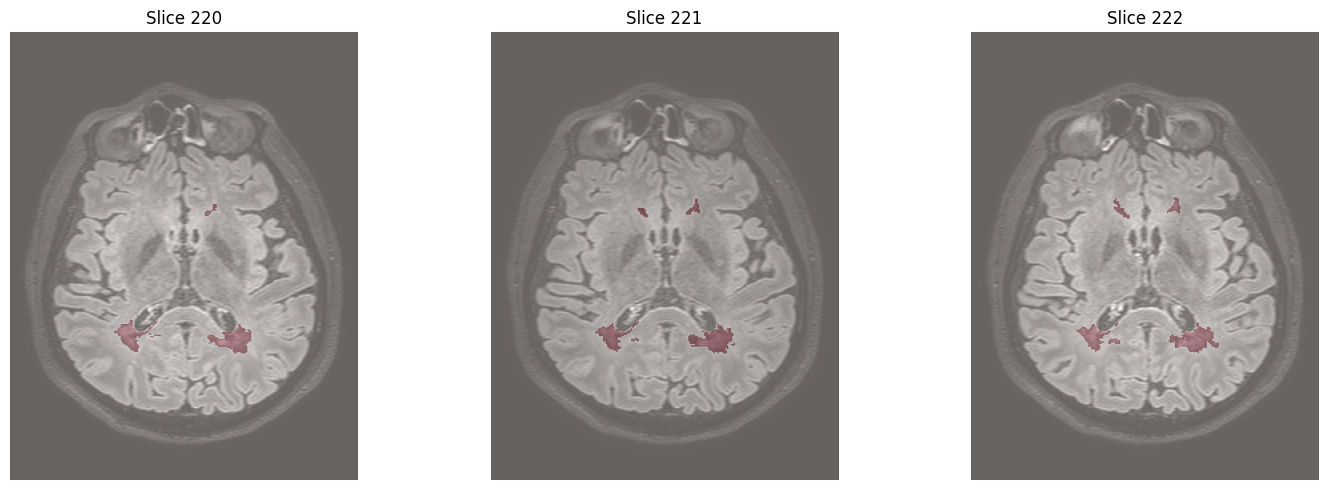

In [7]:
# Afficher la slice axiale 220, 221, 222 et superposer le masque sur le FLAIR pour un patient donné

import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

# --- Paramètres ---
root_dir = '../data'  # Chemin racine des données (adapter si besoin)
patient_name = '08037ROGU'  # Remplace par le nom du patient voulu
slice_idx = 221  # Index de la slice axiale centrale à afficher

# --- Chemins des fichiers ---
patient_path = os.path.join(root_dir, patient_name)
flair_path = os.path.join(patient_path, '3DFLAIR.nii')
mask_path = os.path.join(patient_path, 'Consensus.nii')

# --- Chargement des images ---
flair_img = sitk.GetArrayFromImage(sitk.ReadImage(flair_path))  # shape: [Z, Y, X]
mask_img = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

# --- Vérification des index ---
if slice_idx < 1 or slice_idx > flair_img.shape[0] - 2:
    raise ValueError(f"slice_idx={slice_idx} hors limites pour affichage triple (doit être entre 1 et {flair_img.shape[0]-2})")

# --- Extraction des slices axiales ---
slices = [slice_idx - 1, slice_idx, slice_idx + 1]
img_slices = [flair_img[i, :, :] for i in slices]
mask_slices = [mask_img[i, :, :] for i in slices]

# --- Affichage superposé ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(img_slices[i], cmap='gray')
    ax.imshow(mask_slices[i], cmap='Reds', alpha=0.4)
    ax.set_title(f'Slice {slices[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_4676\2050490041.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


⚠️ Erreur lors du chargement de teeest.pth : Error(s) in loading state_dict for UNet3D:
	Missing key(s) in state_dict: "encoder1.0.weight", "encoder1.0.bias", "encoder1.2.weight", "encoder1.2.bias", "encoder2.0.weight", "encoder2.0.bias", "encoder2.2.weight", "encoder2.2.bias", "encoder3.0.weight", "encoder3.0.bias", "encoder3.2.weight", "encoder3.2.bias", "upconv3.weight", "upconv3.bias", "decoder3.0.weight", "decoder3.0.bias", "decoder3.2.weight", "decoder3.2.bias", "upconv2.weight", "upconv2.bias", "decoder2.0.weight", "decoder2.0.bias", "decoder2.2.weight", "decoder2.2.bias", "upconv1.weight", "upconv1.bias", "decoder1.0.weight", "decoder1.0.bias", "decoder1.2.weight", "decoder1.2.bias", "output.weight", "output.bias". 
	Unexpected key(s) in state_dict: "enc1.0.weight", "enc1.0.bias", "enc1.2.weight", "enc1.2.bias", "enc2.0.weight", "enc2.0.bias", "enc2.2.weight", "enc2.2.bias", "enc3.0.weight", "enc3.0.bias", "enc3.2.weight", "enc3.2.bias", "enc4.0.weight", "enc4.0.bias", "enc4.2.

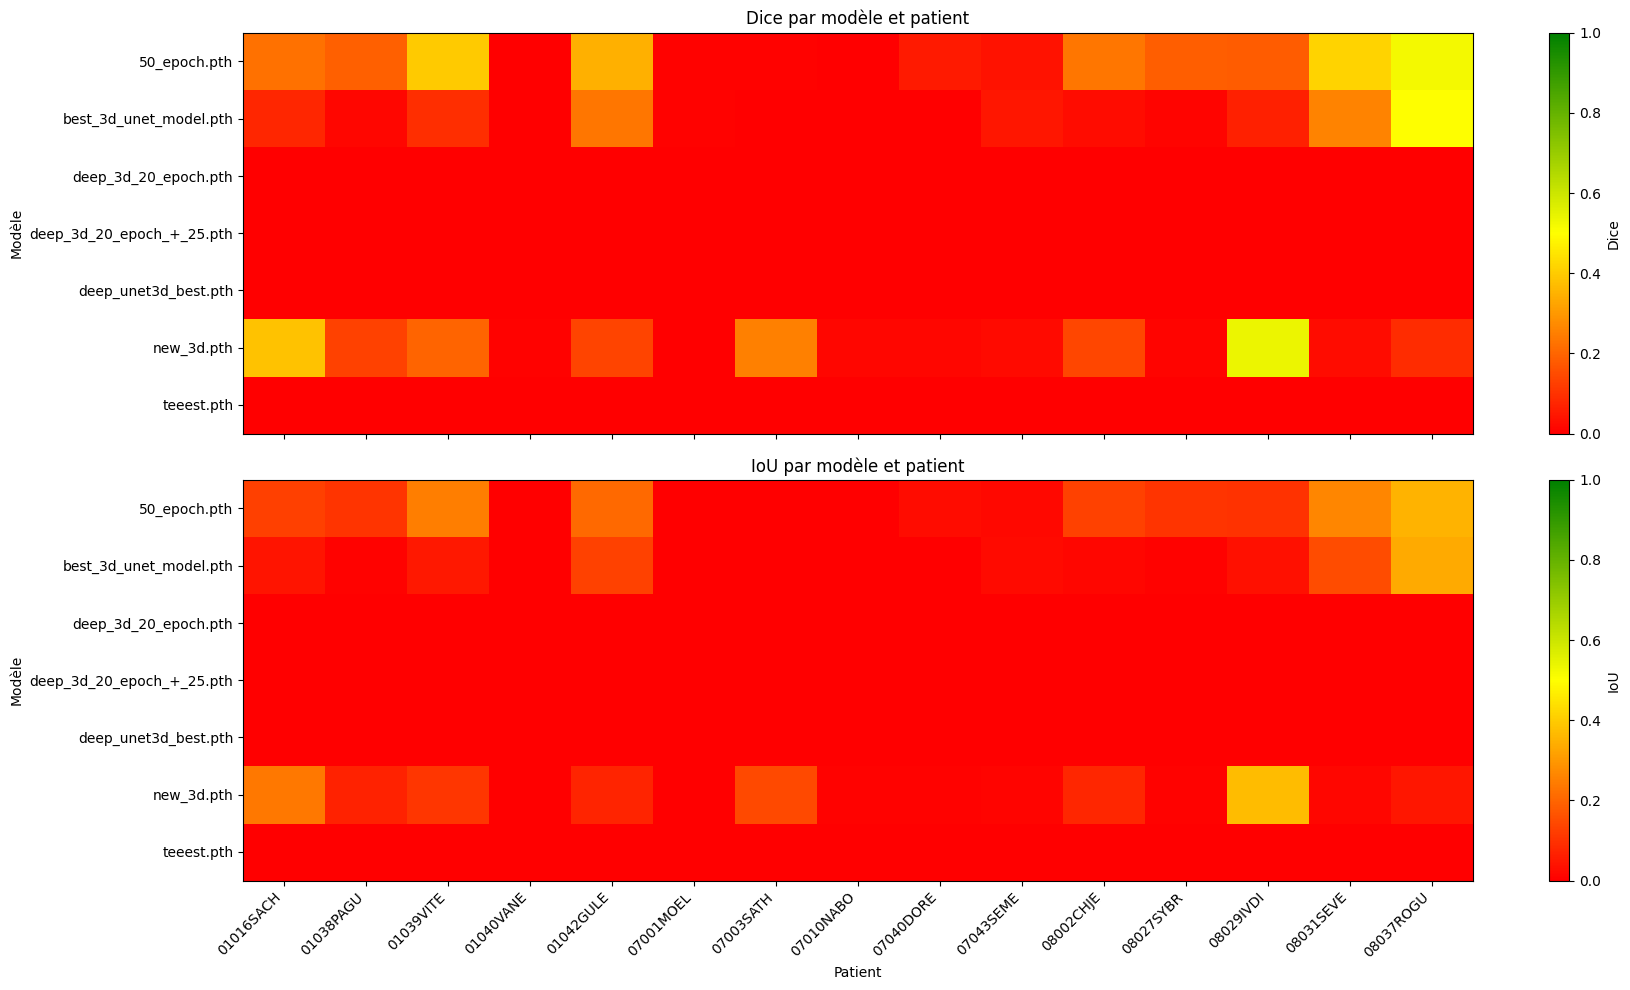

In [8]:
import os
import torch
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Définir les architectures disponibles ---
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = conv_block(128, 256)
        self.upconv3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)
        self.output = nn.Conv3d(32, out_channels, kernel_size=1)
    def forward(self, x):
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.upconv3(b)
        d3 = torch.nn.functional.interpolate(d3, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.nn.functional.interpolate(d2, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.nn.functional.interpolate(d1, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)
        out = self.output(d1)
        return out

class DeepUNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = conv_block(128, 256)
        self.pool4 = nn.MaxPool3d(2)
        self.bottleneck = conv_block(256, 512)
        self.up4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)
    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        b = self.bottleneck(p4)
        d4 = self.up4(b)
        d4 = torch.nn.functional.interpolate(d4, size=e4.shape[2:], mode='trilinear', align_corners=False)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.nn.functional.interpolate(d3, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.nn.functional.interpolate(d2, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.nn.functional.interpolate(d1, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.out_conv(d1)

# --- Détection automatique du type de modèle ---
def get_model_class(model_filename):
    name = model_filename.lower()
    if "deep" in name:
        return DeepUNet3D
    else:
        return UNet3D

# --- Préparation des patients ---
root_dir = '../data'
patient_dirs = [os.path.join(root_dir, p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, p))]
patient_names = [os.path.basename(p) for p in patient_dirs]

# --- Liste des modèles ---
models_dir = "../Modèles/3D/"
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]
model_files.sort()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Matrices pour stocker les scores ---
dice_matrix = np.zeros((len(model_files), len(patient_names)))
iou_matrix = np.zeros((len(model_files), len(patient_names)))

# --- Boucle sur chaque modèle et chaque patient ---
for m_idx, model_file in enumerate(model_files):
    model_path = os.path.join(models_dir, model_file)
    ModelClass = get_model_class(model_file)
    model = ModelClass(in_channels=1, out_channels=1).to(device)
    try:
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"⚠️ Erreur lors du chargement de {model_file} : {e}")
        continue
    model.eval()
    with torch.no_grad():
        for p_idx, patient_path in enumerate(patient_dirs):
            flair_path = os.path.join(patient_path, '3DFLAIR.nii')
            mask_path = os.path.join(patient_path, 'Consensus.nii')
            flair_img = sitk.GetArrayFromImage(sitk.ReadImage(flair_path))
            mask_img = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
            flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
            mask_img_bin = (mask_img > 0).astype(np.uint8)
            flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
            mask_tensor = torch.tensor(mask_img_bin).unsqueeze(0).unsqueeze(0).to(device)
            outputs = torch.sigmoid(model(flair_tensor))
            threshold = 0.4
            preds = (outputs > threshold).float()
            intersection = (preds * mask_tensor).sum().item()
            dice = (2.0 * intersection) / (preds.sum().item() + mask_tensor.sum().item() + 1e-8)
            iou = intersection / ((preds + mask_tensor).clamp(0, 1).sum().item() + 1e-8)
            dice_matrix[m_idx, p_idx] = dice
            iou_matrix[m_idx, p_idx] = iou
    del model
    torch.cuda.empty_cache()

# --- Affichage matplotlib avec colormap rouge-jaune-vert ---
cmap_rjyv = mcolors.LinearSegmentedColormap.from_list("rjyv", ["red", "yellow", "green"])

fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Dice
im1 = axes[0].imshow(dice_matrix, aspect='auto', cmap=cmap_rjyv, vmin=0, vmax=1)
axes[0].set_title('Dice par modèle et patient')
axes[0].set_ylabel('Modèle')
axes[0].set_yticks(np.arange(len(model_files)))
axes[0].set_yticklabels(model_files)
axes[0].set_xticks(np.arange(len(patient_names)))
axes[0].set_xticklabels(patient_names, rotation=45, ha='right')
fig.colorbar(im1, ax=axes[0], label='Dice')

# IoU
im2 = axes[1].imshow(iou_matrix, aspect='auto', cmap=cmap_rjyv, vmin=0, vmax=1)
axes[1].set_title('IoU par modèle et patient')
axes[1].set_ylabel('Modèle')
axes[1].set_xlabel('Patient')
axes[1].set_yticks(np.arange(len(model_files)))
axes[1].set_yticklabels(model_files)
axes[1].set_xticks(np.arange(len(patient_names)))
axes[1].set_xticklabels(patient_names, rotation=45, ha='right')
fig.colorbar(im2, ax=axes[1], label='IoU')

plt.tight_layout()
plt.show()

In [9]:
import os
import torch
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# --- Paramètres ---
models_dir = "../Modèles/3D/"
model_path = os.path.join(models_dir, "50_epoch.pth")
patient_name = "08037ROGU"
root_dir = '../data'
patient_path = os.path.join(root_dir, patient_name)
flair_path = os.path.join(patient_path, '3DFLAIR.nii')
mask_path = os.path.join(patient_path, 'Consensus.nii')

# --- Chargement du modèle UNet3D ---
class UNet3D(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        def conv_block(in_c, out_c):
            return torch.nn.Sequential(
                torch.nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                torch.nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 32)
        self.pool1 = torch.nn.MaxPool3d(2)
        self.encoder2 = conv_block(32, 64)
        self.pool2 = torch.nn.MaxPool3d(2)
        self.encoder3 = conv_block(64, 128)
        self.pool3 = torch.nn.MaxPool3d(2)
        self.bottleneck = conv_block(128, 256)
        self.upconv3 = torch.nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = conv_block(256, 128)
        self.upconv2 = torch.nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = torch.nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)
        self.output = torch.nn.Conv3d(32, out_channels, kernel_size=1)
    def forward(self, x):
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.upconv3(b)
        d3 = torch.nn.functional.interpolate(d3, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.nn.functional.interpolate(d2, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.nn.functional.interpolate(d1, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)
        out = self.output(d1)
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet3D(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Chargement des données ---
flair_img = sitk.GetArrayFromImage(sitk.ReadImage(flair_path))
mask_img = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
mask_img_bin = (mask_img > 0).astype(np.uint8)
flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
mask_tensor = torch.tensor(mask_img_bin).unsqueeze(0).unsqueeze(0).to(device)

# --- Calcul du Dice pour différents seuils ---
thresholds = np.arange(0.01, 1.01, 0.01)
dice_scores = []

with torch.no_grad():
    outputs = torch.sigmoid(model(flair_tensor))
    for t in thresholds:
        preds = (outputs > t).float()
        intersection = (preds * mask_tensor).sum().item()
        dice = (2.0 * intersection) / (preds.sum().item() + mask_tensor.sum().item() + 1e-8)
        dice_scores.append(dice)

# --- Affichage ---
plt.figure(figsize=(8, 5))
plt.plot(thresholds, dice_scores, marker='o')
plt.title("Évolution du Dice pour 08037ROGU selon le seuil de binarisation (modèle 50_epoch)")
plt.xlabel("Seuil de binarisation")
plt.ylabel("Dice")
plt.grid()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_4676\4222372849.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM_STREAM_MISMATCH